### **Term Paper Code: Supervised Classification**
#### **Group - 1**

##### *Start by importing all neccessary Libraries*

In [1]:
# Importing all necessary Libraries
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter import ttk
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from collections import Counter
import contextlib # Added for dummy torch context manager

# --- Scikit-learn Imports ---
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
# importing RPNet Specific Imports with exceptions handling
# --- RPNet Specific Imports (Optional Dependency) ---
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    TORCH_AVAILABLE = True
except ImportError:
    TORCH_AVAILABLE = False
    # Define dummy classes/functions if torch not found
    class nn: Module = object; Parameter = object
    class F:
        @staticmethod
        def conv2d(*args, **kwargs): raise ImportError("PyTorch not found. RPNet requires PyTorch installation.")
    class torch:
        float32 = None
        no_grad = contextlib.contextmanager(lambda: (yield))
        @staticmethod
        def tensor(*args, **kwargs): raise ImportError("PyTorch not found. RPNet requires PyTorch installation.")
        @staticmethod
        def cat(*args, **kwargs): raise ImportError("PyTorch not found. RPNet requires PyTorch installation.")
        @staticmethod
        def from_numpy(*args, **kwargs): raise ImportError("PyTorch not found. RPNet requires PyTorch installation.")
        @staticmethod
        def unsqueeze(*args, **kwargs): raise ImportError("PyTorch not found. RPNet requires PyTorch installation.")
        @staticmethod
        def squeeze(*args, **kwargs): raise ImportError("PyTorch not found. RPNet requires PyTorch installation.")


##### *Main*

In [3]:
# creating Global Variables for GUI
# --- Global Variables ---
corrected_img = None
ground_truth = None


# Creating RPNet Functions for Feature Extraction
# --- RPNet Functions ---

# Creating apply_pca_and_whiten for PCA, takes 
def apply_pca_and_whiten(X, p):
    '''
    Input Parameters:
        X: feature map (R, C, N)
        p: number of PCs to keep
    Output Parameters:
        X_white: whitened feature map (R, C, p) or (R, C, 0)
        pca: PCA object fitted on the data or None
    '''
    if X.ndim != 3:
        raise ValueError(f"Input X must be 3D (R, C, N), but got shape {X.shape}")
    R, C, N = X.shape

    if p <= 0: # Handle case where 0 components are requested explicitly or implicitly
        print(f"Warning: PCA requested with p={p}. Returning zero features.")
        return np.zeros((R, C, 0)), None # Return empty features and None for pca object

    if N < p:
        print(f"Warning: Requested {p} PCA components, but input only has {N} features. Using n_components={N}.")
        p = N # Adjust p to the maximum possible

    if N == 0: # Handle case where input has no features
        print(f"Warning: Input to PCA has 0 features. Returning zero features.")
        return np.zeros((R, C, 0)), None

    reshaped = X.reshape(-1, N)

    try:
        pca = PCA(n_components=p)
        X_pca = pca.fit_transform(reshaped)

        # Check if PCA actually produced components (it might not if variance is zero)
        if X_pca.shape[1] == 0:
             print(f"Warning: PCA resulted in 0 components for p={p} (input shape {N}). Returning zero features.")
             return np.zeros((R, C, 0)), pca # Return empty features

        # Whiten (Standardize PCA components)
        scaler = StandardScaler()
        X_white_flat = scaler.fit_transform(X_pca)
        # Ensure output shape matches requested 'p' (or adjusted 'p')
        return X_white_flat.reshape(R, C, X_pca.shape[1]), pca
    except ValueError as e:
         # Catch errors during fit (e.g., all zero variance input)
         print(f"Error during PCA/Whitening (p={p}, N={N}): {e}. Returning zero features.")
         return np.zeros((R, C, 0)), None # Return empty on error


# extract_random_patches_as_filters (minor robustness)
def extract_random_patches_as_filters(X_white, patch_size, k):
    ''' Extracts k random patches from X_white to be used as Conv filters. '''
    if not TORCH_AVAILABLE:
         raise ImportError("PyTorch not found. RPNet requires PyTorch installation.")
    if X_white.ndim != 3:
        raise ValueError(f"Input X_white must be 3D (R, C, P), but got shape {X_white.shape}")

    R, C, P = X_white.shape
    if P == 0:
        raise ValueError("Input to extract_random_patches_as_filters has 0 features (P=0). Cannot extract filters.")

    pad = patch_size // 2
    # Use 'reflect' padding
    padded = np.pad(X_white, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
    patches = []
    attempts = 0
    max_attempts = k * 5 # Try a bit harder to find patches

    while len(patches) < k and attempts < max_attempts:
        attempts += 1
        # Ensure indices are within valid range for the *original* dimensions R, C
        # We sample center points from the original image grid
        i_center = np.random.randint(0, R)
        j_center = np.random.randint(0, C)
        # Calculate slice indices in the *padded* array
        i_start, i_end = i_center, i_center + patch_size
        j_start, j_end = j_center, j_center + patch_size
        patch = padded[i_start:i_end, j_start:j_end, :]

        if patch.shape == (patch_size, patch_size, P):
            # Transpose to (P, H, W) - Channels first for PyTorch Conv2d filters
            patches.append(np.transpose(patch, (2, 0, 1)))
        else:
             # This case should be rare with correct padding and indexing
             print(f"Warning: Extracted patch shape mismatch. Expected {(patch_size, patch_size, P)}, got {patch.shape}. Indices i_center={i_center}, j_center={j_center}")

    if len(patches) < k:
         print(f"Warning: Could only extract {len(patches)} out of {k} desired patches.")
    if not patches:
        raise ValueError(f"Could not extract any valid patches after {max_attempts} attempts. Check patch_size ({patch_size}), input dimensions ({R},{C},{P}), and padding.")

    # Stack patches to form the filter bank: (num_extracted_patches, P, H, W)
    filter_bank = np.stack(patches)
    return torch.tensor(filter_bank, dtype=torch.float32)


class RPNetFixedLayer(nn.Module):
    def __init__(self, filters):
        super(RPNetFixedLayer, self).__init__()
        if not TORCH_AVAILABLE:
             raise ImportError("PyTorch not found. RPNet requires PyTorch installation.")
        self.filters = nn.Parameter(filters, requires_grad=False)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        elif x.dtype != torch.float32:
            x = x.float()
        # filters shape: (C_out=k, C_in=P, kH, kW)
        return F.conv2d(x, self.filters, padding='same')

# run_rpnet_layers
def run_rpnet_layers(X_input, patch_size, k, L, initial_pca_components=4):
    """ Runs RPNet. Returns (R, C, Features) or (R, C, 0) if fails. """
    if not TORCH_AVAILABLE:
        raise ImportError("PyTorch not found. RPNet requires PyTorch installation.")

    print(f"Running RPNet: patch_size={patch_size}, k={k}, L={L}, initial_pca={initial_pca_components}")
    R_orig, C_orig, N_orig = X_input.shape

    # follow these steps to for running the RPNet:
    # 1. Initial PCA and Whitening
    print("  - Applying initial PCA...")
    current_feature_map, _ = apply_pca_and_whiten(X_input, initial_pca_components)
    if current_feature_map.shape[-1] == 0:
         print("  - Error: Initial PCA resulted in 0 features. Aborting RPNet.")
         return np.zeros((R_orig, C_orig, 0))                       # Return empty features
    print(f"  - Initial PCA output shape: {current_feature_map.shape}")

    feature_stack = []

    for layer_idx in range(L):
        print(f"  - Processing RPNet Layer {layer_idx + 1}/{L}...")
        current_R, current_C, current_P = current_feature_map.shape

        # 2. Intermediate PCA (if not first layer)
        if layer_idx > 0:
             print(f"    - Applying intermediate PCA (target 4 components)...")
             intermediate_pca_target = 4
             current_feature_map, _ = apply_pca_and_whiten(current_feature_map, intermediate_pca_target)
             # Check if intermediate PCA failed
             if current_feature_map.shape[-1] == 0:
                 print(f"    - Error: Intermediate PCA resulted in 0 features at layer {layer_idx + 1}. Stopping RPNet processing.")
                 break # Stop adding layers if features vanish
             print(f"    - Intermediate PCA output shape: {current_feature_map.shape}")
             # Update P for filter extraction
             current_P = current_feature_map.shape[-1]

        # 3. Extract Filters
        print(f"    - Extracting {k} random patches (size {patch_size}x{patch_size})...")
        try:
            # Check if there are enough features to extract patches from
            if current_P == 0:
                print("    - Error: Cannot extract patches with 0 input features. Stopping layer processing.")
                break
            filters = extract_random_patches_as_filters(current_feature_map, patch_size, k)
            # Update k if fewer filters were extracted
            actual_k = filters.shape[0]
            print(f"    - Actual filters extracted: {actual_k}. Shape: {filters.shape}")
        except ValueError as e:
            print(f"    - Error extracting patches: {e}. Stopping RPNet processing.")
            break # Stop if filters cannot be created

        # 4. Prepare Input Tensor for Convolution
        #    Input needs shape (1, P, R, C)
        inp_tensor = torch.tensor(current_feature_map.transpose(2, 0, 1)).unsqueeze(0)
        print(f"    - Input tensor shape for Conv2D: {inp_tensor.shape}")

        # 5. Define and Apply Fixed Convolution Layer
        model = RPNetFixedLayer(filters)
        with torch.no_grad():
            output_tensor = model(inp_tensor)               # Output shape (1, actual_k, R, C)

        # 6. Process Output
        output_map = output_tensor.squeeze(0).numpy().transpose(1, 2, 0) # Shape (R, C, actual_k)
        print(f"    - Output map shape for layer {layer_idx + 1}: {output_map.shape}")

        feature_stack.append(output_map)
        current_feature_map = output_map                    # Output of this layer is input for next

    # 7. Concatenate features
    if not feature_stack:
         print("Warning: RPNet generated no feature maps in any layer.")
         return np.zeros((R_orig, C_orig, 0)) # Return shape (R, C, 0)

    try:
        final_features = np.concatenate(feature_stack, axis=-1)
        print(f"  - Final RPNet features concatenated. Shape: {final_features.shape}")
        # Ensure final shape matches original spatial dimensions
        if final_features.shape[:2] != (R_orig, C_orig):
             print(f"Warning: Final RPNet feature spatial dimensions {final_features.shape[:2]} don't match original {R_orig, C_orig}. This shouldn't happen with 'same' padding.")
             # Attempt to resize? Or return empty? For now, return empty.
             return np.zeros((R_orig, C_orig, 0))
        return final_features
    except ValueError as e:
         print(f"Error concatenating RPNet features: {e}. Feature stack shapes: {[f.shape for f in feature_stack]}")
         return np.zeros((R_orig, C_orig, 0))

# compile all the featurrses together in  using combined_features function 
def combined_features(spatial_feat, spectral_data):
    """ Combines RPNet spatial features and original spectral data. Handles empty spatial_feat. """
    print("Combining features...")
    R, C, N = spectral_data.shape

    # --- Handle Spectral Data ---
    spectral_flat = spectral_data.reshape(-1, N)
    scaler_spectral = StandardScaler()
    spectral_scaled_flat = scaler_spectral.fit_transform(spectral_flat)
    print(f"  - Scaled spectral features shape: {spectral_scaled_flat.shape}")

    # --- Handle Spatial Data ---
    if spatial_feat is None or spatial_feat.size == 0 or spatial_feat.shape[-1] == 0:
        print("  - No valid spatial features provided. Using only spectral features.")
        # No spatial features, return only scaled spectral (already flat)
        # We still need to scale them together IF spatial existed, but here only spectral exists.
        # So, scale spectral alone.
        scaler_combined = StandardScaler()
        combined_scaled_flat = scaler_combined.fit_transform(spectral_scaled_flat)
        print(f"  - Final combined scaled flat shape (spectral only): {combined_scaled_flat.shape}")
        return combined_scaled_flat
    else:
        # Spatial features exist
        S = spatial_feat.shape[-1]                                  # Number of spatial features
        print(f"  - Processing {S} spatial features.")
        spatial_flat = spatial_feat.reshape(-1, S)
        scaler_spatial = StandardScaler()
        spatial_scaled_flat = scaler_spatial.fit_transform(spatial_flat)
        print(f"  - Scaled spatial features shape: {spatial_scaled_flat.shape}")

        # --- Combine Scaled Features ---
        combined_flat = np.concatenate([spectral_scaled_flat, spatial_scaled_flat], axis=-1)
        print(f"  - Combined flat shape before final scaling: {combined_flat.shape}")

        # Scale the combined features together
        scaler_combined = StandardScaler()
        combined_scaled_flat = scaler_combined.fit_transform(combined_flat)
        print(f"  - Final combined scaled flat shape: {combined_scaled_flat.shape}")
        return combined_scaled_flat

#### *Create the Final GUI functions and GUI*

Loaded corrected image: shape=(512, 614, 176), dtype=float32
Features extracted successfully: shape=(314368, 176)


C:\Users\sidan\AppData\Local\Temp\ipykernel_2676\4150111003.py:272: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max_class_val + 1)


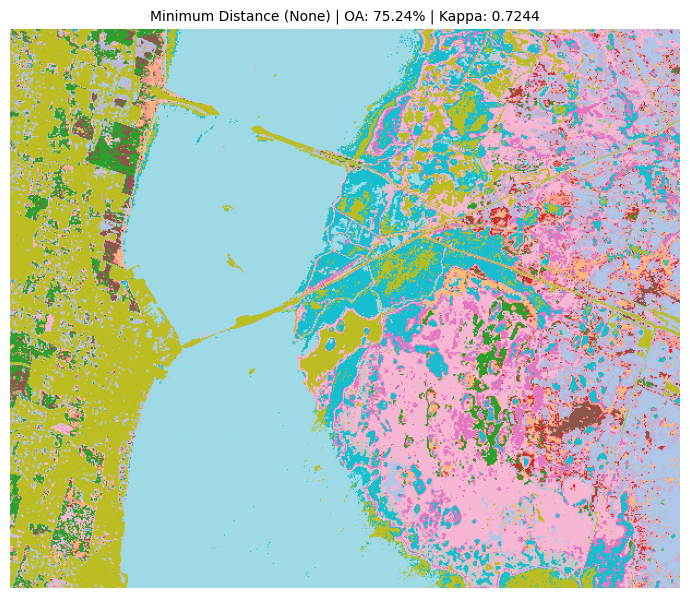

Features extracted successfully: shape=(314368, 176)


C:\Users\sidan\AppData\Local\Temp\ipykernel_2676\4150111003.py:272: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max_class_val + 1)


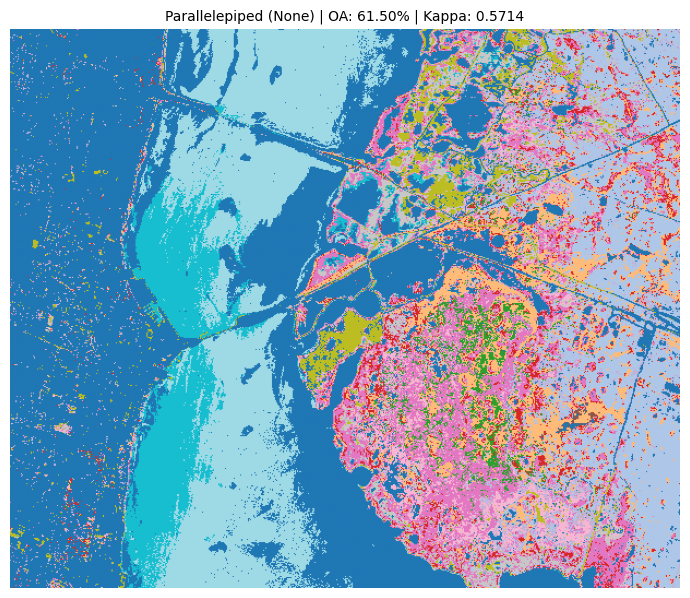

Features extracted successfully: shape=(314368, 176)


C:\Users\sidan\AppData\Local\Temp\ipykernel_2676\4150111003.py:272: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max_class_val + 1)


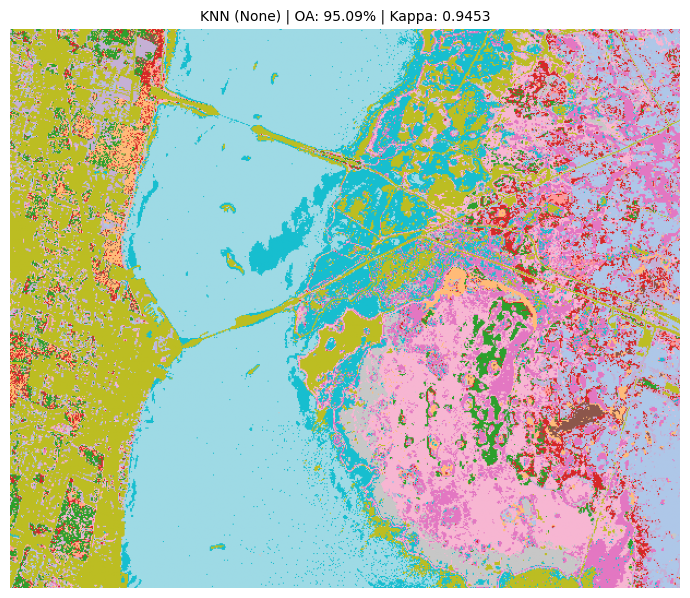

Features extracted successfully: shape=(314368, 176)


C:\Users\sidan\AppData\Local\Temp\ipykernel_2676\4150111003.py:272: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max_class_val + 1)


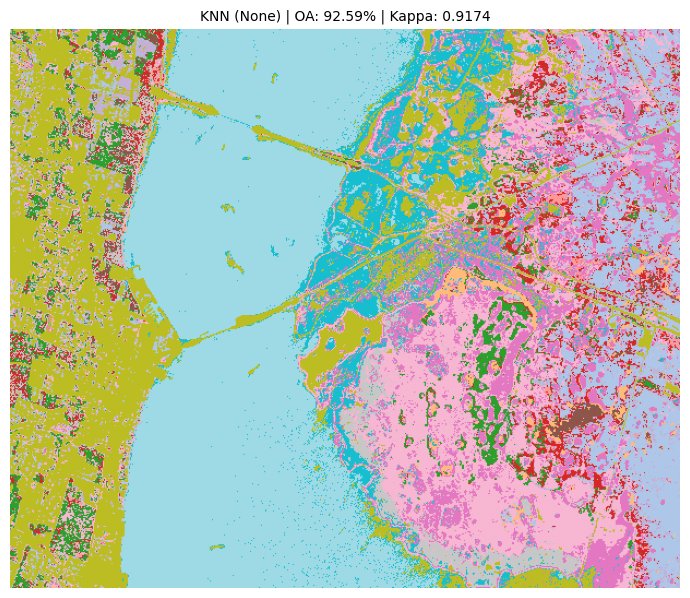

Features extracted successfully: shape=(314368, 176)


C:\Users\sidan\AppData\Local\Temp\ipykernel_2676\4150111003.py:272: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max_class_val + 1)


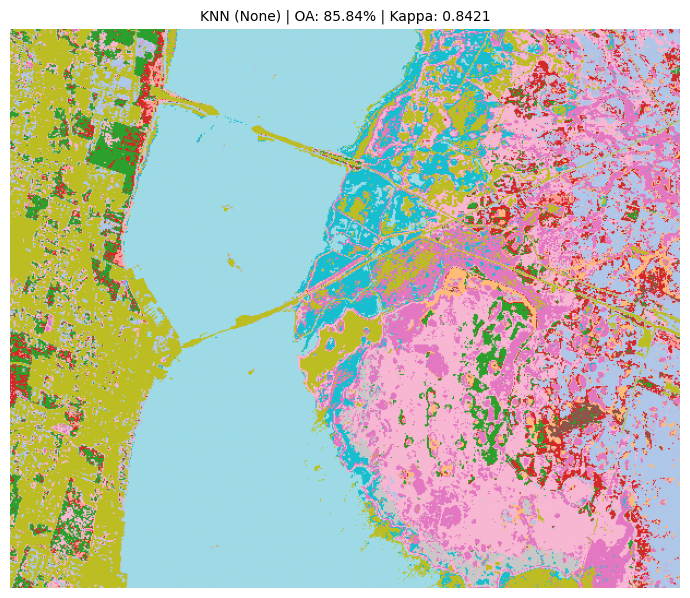

Features extracted successfully: shape=(314368, 176)


C:\Users\sidan\AppData\Local\Temp\ipykernel_2676\4150111003.py:272: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max_class_val + 1)


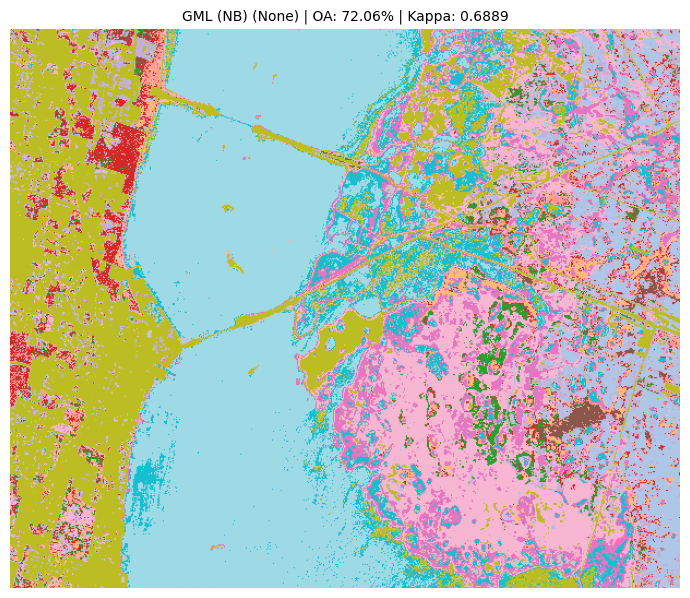

Features extracted successfully: shape=(314368, 176)


c:\Users\sidan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\sidan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\sidan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\sidan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is 

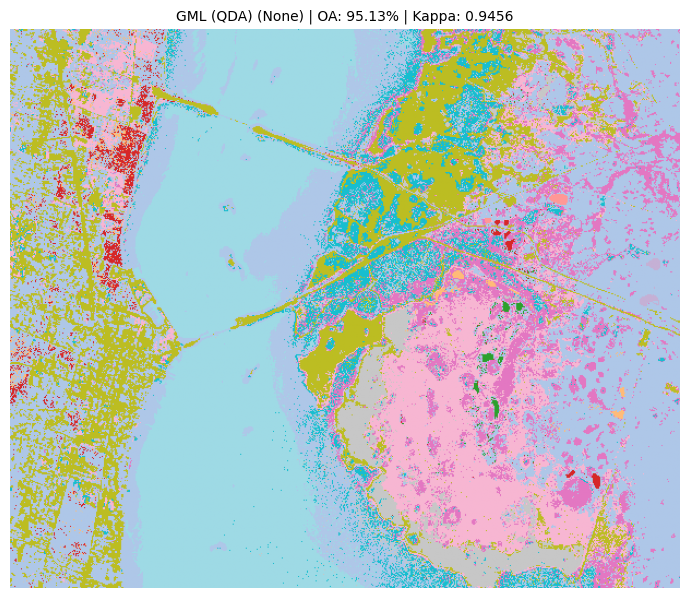

Features extracted successfully: shape=(314368, 176)


C:\Users\sidan\AppData\Local\Temp\ipykernel_2676\4150111003.py:272: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max_class_val + 1)


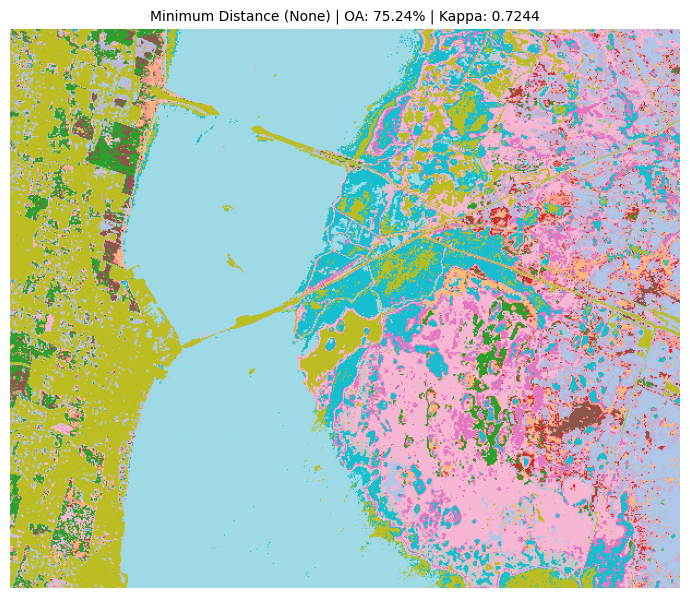

Features extracted successfully: shape=(314368, 176)


C:\Users\sidan\AppData\Local\Temp\ipykernel_2676\4150111003.py:272: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max_class_val + 1)


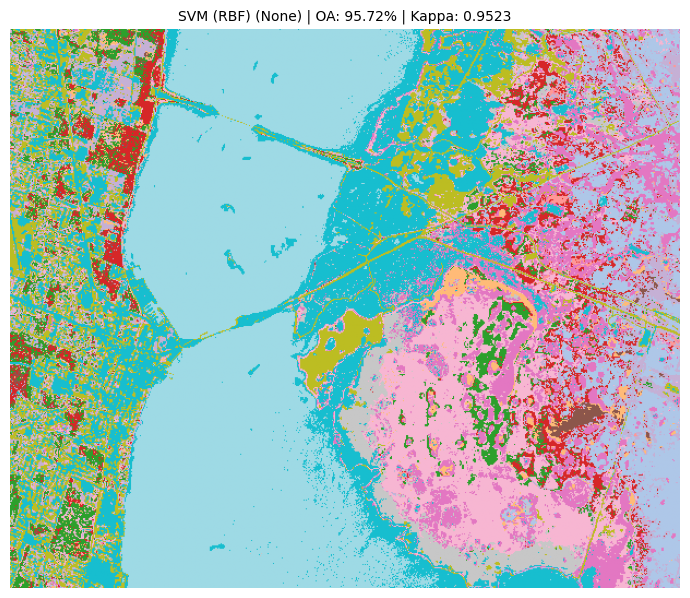

Features extracted successfully: shape=(314368, 176)


C:\Users\sidan\AppData\Local\Temp\ipykernel_2676\4150111003.py:272: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max_class_val + 1)


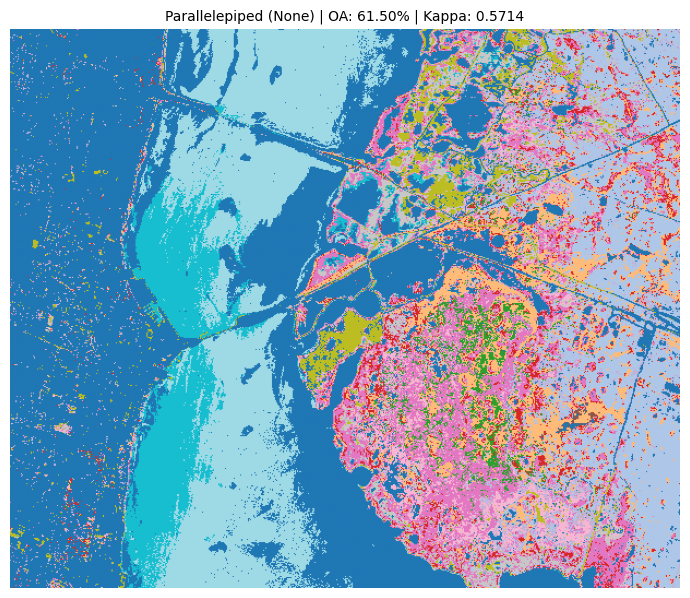

In [4]:

# --- GUI Functions ---
# function to laod the corrected or Raw file
def load_corrected_file():
    global corrected_img
    path = filedialog.askopenfilename(title="Select Corrected Image (.mat)", filetypes=[("MAT files", "*.mat")])
    if path:
        try:
            data = scipy.io.loadmat(path)
            potential_keys = [k for k, v in data.items() if isinstance(v, np.ndarray) and v.ndim == 3]
            if not potential_keys:
                raise ValueError("No 3D numpy array found in corrected MAT file.")
            img_key = max(potential_keys, key=lambda k: data[k].size)
            corrected_img = data[img_key].astype(np.float32)            # Ensure float32
            status_label.config(text=f"✅ Corrected image loaded (key: '{img_key}')", fg='green')
            status_label2.config(text=f"Shape: {corrected_img.shape}, Bands: {corrected_img.shape[2]}, Type: {corrected_img.dtype}")
            print(f"Loaded corrected image: shape={corrected_img.shape}, dtype={corrected_img.dtype}")
        except Exception as e:
            corrected_img = None
            status_label.config(text=f"❌ Error loading corrected image: {e}", fg='red')
            status_label2.config(text="")
            messagebox.showerror("Load Error", f"Failed to load corrected image:\n{e}")

# function to load the Ground Truth File 
def load_gt_file():
    global ground_truth
    path = filedialog.askopenfilename(title="Select Ground Truth (.mat)", filetypes=[("MAT files", "*.mat")])
    if path:
        try:
            data = scipy.io.loadmat(path)
            potential_keys = [k for k, v in data.items() if isinstance(v, np.ndarray) and v.ndim == 2]
            if not potential_keys:
                raise ValueError("No 2D numpy array found in ground truth MAT file.")
            gt_key = max(potential_keys, key=lambda k: data[k].size)
            ground_truth = data[gt_key]
            ground_truth = ground_truth.astype(int)                     # Ensure GT is integer type
            status_label.config(text=f"✅ Ground truth loaded (key: '{gt_key}')", fg='green')
            status_label2.config(text=f"Shape: {ground_truth.shape}, Classes: {len(np.unique(ground_truth))}")
        except Exception as e:
            ground_truth = None
            status_label.config(text=f"❌ Error loading ground truth: {e}", fg='red')
            status_label2.config(text="")
            messagebox.showerror("Load Error", f"Failed to load ground truth:\n{e}")

# Function for enabling PCA
def toggle_pca_options(*args):
    """Enable/disable PCA components entry based on feature extraction choice."""
    if feature_extraction_method.get() == "PCA":
        pca_label.config(state=tk.NORMAL)
        pca_entry.config(state=tk.NORMAL)
    else:
        pca_label.config(state=tk.DISABLED)
        pca_entry.config(state=tk.DISABLED)

# --- classify_and_display Function ---
def classify_and_display():
    # (Initial checks for loaded data and matching dimensions are unchanged) ---> they will be highlighted in the status bar of our GUI
    if corrected_img is None or ground_truth is None:
        messagebox.showerror("Error", "Please load both corrected image and ground truth files.")
        status_label.config(text="❌ Load both corrected and ground truth files first!", fg='red')
        return
    if corrected_img.shape[:2] != ground_truth.shape:
         messagebox.showerror("Error", f"Image dimensions {corrected_img.shape[:2]} do not match Ground Truth dimensions {ground_truth.shape}.")
         status_label.config(text="❌ Image and Ground Truth dimensions do not match!", fg='red')
         status_label2.config(text=f"Image: {corrected_img.shape[:2]}, GT: {ground_truth.shape}")
         return

    feature_method = feature_extraction_method.get()
    clf_name = classifier_type.get()

    status_label.config(text=f"⏳ Preparing data (Feature Method: {feature_method})...", fg='blue')
    status_label2.config(text="")
    gui_frame.update_idletasks()

    try:
        h, w, b = corrected_img.shape               # height, width , bands
        gt_flat = ground_truth.ravel()              # sinle band image 

        # --- Feature Extraction ---
        X_extracted_flat = None                     # Will hold the features for all pixels (h*w, num_features)
        num_features = 0

        # Apply method for feature extraction 
        # None ---> takes raw image and classifies
        if feature_method == "None":
            status_label2.config(text="Using raw spectral features.")
            gui_frame.update_idletasks()
            X_extracted_flat = corrected_img.reshape(-1, b)

        # PCA -----> for dimessionality reduction (faster)
        elif feature_method == "PCA":
            n_comp = pca_components.get()
            if n_comp <= 0 or n_comp > b:
                 messagebox.showerror("Error", f"Number of PCA components must be between 1 and {b}.")
                 status_label.config(text=f"❌ Invalid PCA components (1-{b})", fg='red')
                 return
            status_label.config(text=f"⏳ Applying PCA ({n_comp} components)...", fg='blue')
            gui_frame.update_idletasks()
            # Use apply_pca_and_whiten to get scaled PCA features directly
            # We need the flat version, so reshape input and apply
            pca_features_scaled_flat, pca_obj = apply_pca_and_whiten(corrected_img, n_comp)
            # Reshape the output of apply_pca_and_whiten (which is R,C,P) back to flat
            if pca_features_scaled_flat.shape[-1] == 0:
                messagebox.showerror("Error", f"PCA resulted in 0 components.")
                status_label.config(text=f"❌ PCA failed to produce components.", fg='red')
                return
            X_extracted_flat = pca_features_scaled_flat.reshape(-1, pca_features_scaled_flat.shape[-1])
            explained_variance = np.sum(pca_obj.explained_variance_ratio_) * 100 if pca_obj else 0
            status_label2.config(text=f"PCA Applied ({X_extracted_flat.shape[1]} comps). Var: {explained_variance:.2f}%")
            print(f"PCA completed. Output shape: {X_extracted_flat.shape}")

        # RPNet ------> More Robust for Feature extraction in classification problems (does that by using patch selection)
        elif feature_method == "RPNet":
            if not TORCH_AVAILABLE:
                messagebox.showerror("Dependency Error", "RPNet requires PyTorch.\nPlease install it (e.g., `pip install torch`).")
                status_label.config(text="❌ RPNet requires PyTorch. Please install it.", fg='red')
                return

            status_label.config(text="⏳ Running RPNet Feature Extraction (can take time)...", fg='blue')
            gui_frame.update_idletasks()

            rp_patch_size = 20; rp_k = 10; rp_L = 3; rp_initial_pca = 4

            spatial_features_map = run_rpnet_layers(corrected_img, rp_patch_size, rp_k, rp_L, rp_initial_pca) # Shape (R, C, k*L or 0)

            # Check if RPNet produced any features before combining
            if spatial_features_map.shape[-1] == 0:
                 status_label2.config(text="RPNet failed to generate spatial features. Using spectral only.")
                 print("RPNet returned 0 features. Proceeding with spectral only for combination.")
                 # combined_features will handle the zero-feature case now
            else:
                status_label2.config(text="RPNet spatial features generated. Combining with spectral...")

            gui_frame.update_idletasks()
            X_extracted_flat = combined_features(spatial_features_map, corrected_img)           # Shape (R*C, CombinedFeatures)

            status_label2.config(text=f"Feature combination complete. Total features: {X_extracted_flat.shape[1]}")
            print(f"RPNet+Combined completed. Output shape: {X_extracted_flat.shape}")


        else:
             messagebox.showerror("Error", "Unknown feature extraction method selected.")
             status_label.config(text="❌ Unknown feature extraction method selected.", fg='red')
             return

        # --- Check if features were actually extracted ---
        if X_extracted_flat is None or X_extracted_flat.size == 0:
             messagebox.showerror("Error", f"Feature extraction ({feature_method}) failed to produce any features.")
             status_label.config(text=f"❌ Feature extraction ({feature_method}) produced no data.", fg='red')
             return
        num_features = X_extracted_flat.shape[1]
        print(f"Features extracted successfully: shape={X_extracted_flat.shape}")


        # --- Prepare Training/Prediction Data ---
        status_label.config(text="⏳ Preparing training data...", fg='blue')
        gui_frame.update_idletasks()

        if remove_bg.get(): train_mask = gt_flat > 0
        else: train_mask = gt_flat >= 0

        X_train_raw = X_extracted_flat[train_mask]
        y_train = gt_flat[train_mask]

        if X_train_raw.shape[0] == 0:
             messagebox.showerror("Error", "No training samples found. Check ground truth or 'Exclude background' option.")
             status_label.config(text="❌ No training samples found with the current background setting.", fg='red')
             return

        status_label2.config(text=f"Training samples: {X_train_raw.shape[0]}, Features: {num_features}")
        gui_frame.update_idletasks()

        # --- Scaling ---
        # NOTE: The extracted features from PCA/RPNet might already be scaled.
        # Re-scaling here ensures consistency, fitting on train and applying to all.
        status_label.config(text="⏳ Scaling features (fit on train)...", fg='blue')
        gui_frame.update_idletasks()
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_raw)
        X_predict_scaled = scaler.transform(X_extracted_flat) # Use same scaler for prediction data

        # now apply for classification 
        # --- Classification ---
        # (Classification logic remains the same, using X_train_scaled and X_predict_scaled)
        status_label.config(text=f"⏳ Training {clf_name}...", fg='blue')
        gui_frame.update_idletasks()

        clf = None
        preds_flat = None                                     # Predictions for the entire image (flat)

        unique_classes_train = np.unique(y_train)

        # Classifier fitting and prediction logic 
        # for Minimum distance to means Classifier -----> Distance metric is Euclidean Distance 
        if clf_name == 'Minimum Distance':
            clf = NearestCentroid(metric='euclidean')
            clf.fit(X_train_scaled, y_train)
            preds_flat = clf.predict(X_predict_scaled)

        # For Parallelepiped classifier (created mmanually)
        elif clf_name == 'Parallelepiped':
             class_bounds = {}
             preds_flat = np.zeros(X_predict_scaled.shape[0], dtype=int)
             for c in unique_classes_train:
                 if c == 0 and remove_bg.get(): continue
                 X_c = X_train_scaled[y_train == c]
                 if X_c.shape[0] > 0:
                     min_vals = np.min(X_c, axis=0); max_vals = np.max(X_c, axis=0)
                     class_bounds[c] = {'min': min_vals, 'max': max_vals}
             for c in unique_classes_train:
                  if c in class_bounds:
                     is_within = np.all((X_predict_scaled >= class_bounds[c]['min']) & (X_predict_scaled <= class_bounds[c]['max']), axis=1)
                     preds_flat[is_within & (preds_flat == 0)] = c
        
        # other classifiers created directly form skleaarn
        # GML(NB) ---> Gaussina Maximum Likelihood Classifier using Naive Bayes (Assumes all classes to follow Gaussian Distribution)
        elif clf_name == 'GML (NB)':
            clf = GaussianNB()
            clf.fit(X_train_scaled, y_train)
            preds_flat = clf.predict(X_predict_scaled)
        
        # GML(QDA) ---> Gaussina Maximum Likelihood Classifier using Quadratic Discrimiantory Analysis (DOES NOT Assumes all classes to follow Gaussian Distribution) [Robust]
        elif clf_name == 'GML (QDA)':
             try:
                 clf = QuadraticDiscriminantAnalysis()
                 clf.fit(X_train_scaled, y_train)
                 preds_flat = clf.predict(X_predict_scaled)
             except Exception as qda_error:
                  messagebox.showerror("QDA Error", f"QDA failed. This can happen if a class has too few samples for the number of features.\nError: {qda_error}")
                  status_label.config(text=f"❌ QDA Error: {qda_error}", fg='red')
                  return
    
        # K Nearest Neighbour Classifier (direct from Sklearn) 
        elif clf_name == 'KNN':
            k = k_value.get()
            if k <= 0:
                messagebox.showerror("Error", "K value for KNN must be positive.")
                status_label.config(text="❌ K value must be positive.", fg='red')
                return
            clf = KNeighborsClassifier(n_neighbors=k)
            clf.fit(X_train_scaled, y_train)
            preds_flat = clf.predict(X_predict_scaled)

        # Suppoort Vector Machines Classifier (direct from Sklearn)
        elif clf_name == 'SVM (RBF)':
            clf = SVC(kernel='rbf', C=10, gamma='scale', probability=False)
            clf.fit(X_train_scaled, y_train)
            preds_flat = clf.predict(X_predict_scaled)

        # check for predictions
        if preds_flat is None:
             messagebox.showerror("Error", "Classification step failed to produce predictions.")
             status_label.config(text="❌ Classification failed.", fg='red')
             return

        classified_map = preds_flat.reshape(h, w)

        # --- Evaluation (on training pixels) ---
        status_label.config(text="⏳ Evaluating...", fg='blue')
        gui_frame.update_idletasks()
        y_pred_train = preds_flat[train_mask]
        labels_present = np.unique(np.concatenate((y_train, y_pred_train)))
        cm = confusion_matrix(y_train, y_pred_train, labels=labels_present)
        oa = accuracy_score(y_train, y_pred_train) * 100
        kappa = cohen_kappa_score(y_train, y_pred_train)
        status_label.config(text="✅ Classification Complete!", fg='green')
        status_label2.config(text=f"OA: {oa:.2f}%, Kappa: {kappa:.4f} (evaluated on training pixels)")


        # --- Plotting --- (plot the result with accuracy and type of classifier)
        fig, ax = plt.subplots(figsize=(7, 7))
        max_class_val = np.max(ground_truth) if ground_truth is not None else 1
        cmap = plt.cm.get_cmap('tab20', max_class_val + 1)
        im = ax.imshow(classified_map, cmap=cmap, vmin=0, vmax=max_class_val)
        ax.set_title(f"{clf_name} ({feature_method}) | OA: {oa:.2f}% | Kappa: {kappa:.4f}", fontsize=10)
        ax.axis('off')
        plt.tight_layout()
        plt.show()

    # --- Exception Handling  ---
    except ImportError as imp_err:
         messagebox.showerror("Import Error", f"{imp_err}\nMake sure required libraries (like PyTorch for RPNet) are installed.")
         status_label.config(text=f"❌ Import Error: {imp_err}", fg='red')
    except Exception as e:
        messagebox.showerror("Processing Error", f"An error occurred during {status_label.cget('text')}:\n{e}")
        status_label.config(text=f"❌ Error during processing: {e}", fg='red')
        status_label2.config(text="Check console for detailed traceback.")
        import traceback
        print("\n--- Error Traceback ---")
        traceback.print_exc()
        print("---------------------\n")


# --- GUI Setup  ---
# Main (root) GUI
gui_frame = tk.Tk()
gui_frame.geometry("500x650")
gui_frame.resizable(False, False)
gui_frame.title("Hyperspectral Classification GUI V2.1 (RPNet Fix)")

# --- Variables ---
feature_extraction_method = tk.StringVar(value="None")
classifier_type = tk.StringVar(value="Minimum Distance")
k_value = tk.IntVar(value=5)
pca_components = tk.IntVar(value=4)
remove_bg = tk.BooleanVar(value=True)

# --- Frames ---
load_frame = ttk.LabelFrame(gui_frame, text="1. Load Data")
load_frame.pack(pady=10, padx=10, fill='x')
feature_frame = ttk.LabelFrame(gui_frame, text="2. Feature Extraction Method")
feature_frame.pack(pady=5, padx=10, fill='x')
classify_frame = ttk.LabelFrame(gui_frame, text="3. Classification Method")
classify_frame.pack(pady=5, padx=10, fill='x')
options_frame = ttk.LabelFrame(gui_frame, text="4. Additional Options")
options_frame.pack(pady=5, padx=10, fill='x')
run_frame = tk.Frame(gui_frame)
run_frame.pack(pady=10, padx=10, fill='x')
status_frame = ttk.LabelFrame(gui_frame, text="Status")
status_frame.pack(pady=5, padx=10, fill='x', expand=True)

# --- Widgets ---
# Load Frame
tk.Button(load_frame, text="Load Corrected Image (.mat)", command=load_corrected_file).pack(pady=5, padx=10, fill='x')
tk.Button(load_frame, text="Load Ground Truth (.mat)", command=load_gt_file).pack(pady=5, padx=10, fill='x')

# Feature Frame
tk.Label(feature_frame, text="Select Method:").grid(row=0, column=0, padx=5, pady=5, sticky='w')
feature_dropdown = ttk.Combobox(feature_frame, textvariable=feature_extraction_method, values=["None", "PCA", "RPNet"], state="readonly", width=15)
feature_dropdown.grid(row=0, column=1, padx=5, pady=5, sticky='w')
feature_dropdown.bind("<<ComboboxSelected>>", toggle_pca_options)
pca_label = tk.Label(feature_frame, text="PCA Components:")
pca_label.grid(row=1, column=0, padx=5, pady=2, sticky='e')
pca_entry = tk.Entry(feature_frame, textvariable=pca_components, width=5)
pca_entry.grid(row=1, column=1, padx=5, pady=2, sticky='w')
toggle_pca_options() # Initial state

# Classification Frame
tk.Label(classify_frame, text="Select Classifier:").grid(row=0, column=0, padx=5, pady=5, sticky='w')
classifier_dropdown = ttk.Combobox(classify_frame, textvariable=classifier_type, values=['Minimum Distance', 'Parallelepiped', 'GML (NB)', 'GML (QDA)', 'KNN', 'SVM (RBF)'], state="readonly", width=25)
classifier_dropdown.grid(row=0, column=1, columnspan=2, padx=5, pady=5, sticky='w')
knn_label = tk.Label(classify_frame, text="K value (for KNN only):")
knn_label.grid(row=1, column=0, padx=5, pady=5, sticky='e')
knn_entry = tk.Entry(classify_frame, textvariable=k_value, width=5)
knn_entry.grid(row=1, column=1, padx=5, pady=5, sticky='w')

# Options Frame
bg_check = tk.Checkbutton(options_frame, text="Exclude background (GT=0) for Training", variable=remove_bg)
bg_check.pack(padx=5, pady=5, anchor='w')

# Run Frame
tk.Button(run_frame, text="Run Classification and Display", command=classify_and_display, font=("Arial", 10, "bold")).pack(pady=10)

# Status Frame
status_label = tk.Label(status_frame, text="Load files to begin.", fg='blue', wraplength=450, justify="left", anchor='nw')
status_label.pack(pady=2, padx=5, fill='x')
status_label2 = tk.Label(status_frame, text="", fg='darkblue', wraplength=450, justify="left", anchor='nw')
status_label2.pack(pady=2, padx=5, fill='x')

# --- Main Loop ---
gui_frame.mainloop()
